In [4]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
dataset = pd.read_csv('proj2dataset.csv')

In [6]:
nltk.download('punkt')
dataset['tokenized_text'] = dataset['comment_text'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(dataset['comment_text'])

In [8]:
X = tfidf_matrix
y = dataset.drop(columns=['id', 'comment_text'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

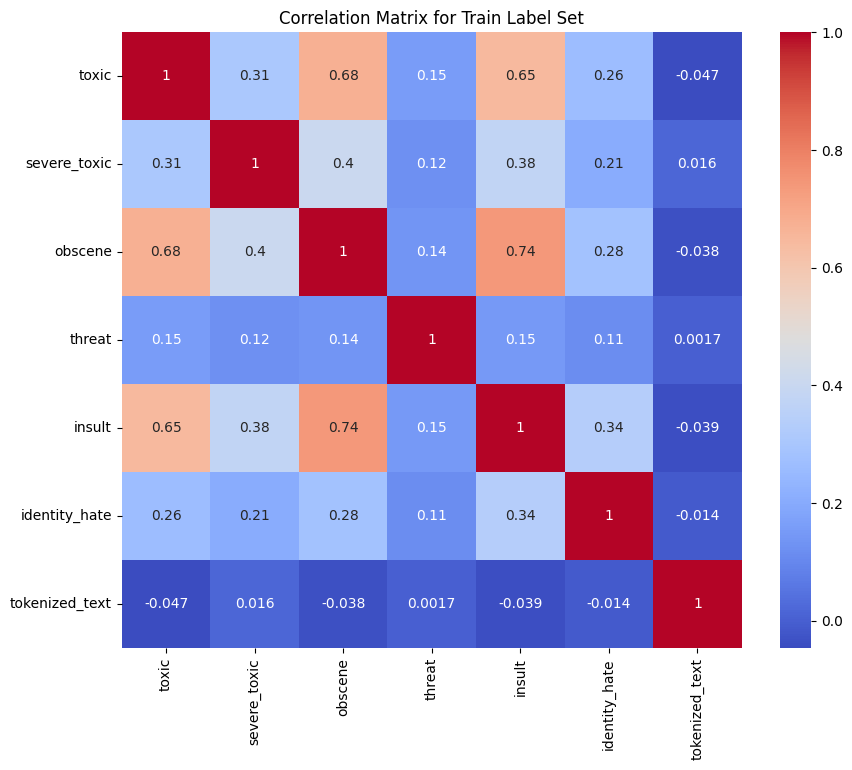

In [11]:
for column in y_train.select_dtypes(include=['object']).columns:
    if any(isinstance(item, list) for item in y_train[column]):
        y_train[column] = y_train[column].apply(lambda x: len(x) if isinstance(x, list) else x)

plt.figure(figsize=(10, 8))
sns.heatmap(y_train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Train Label Set')
plt.show()

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier

In [13]:
X = dataset['comment_text']
Y = dataset['toxic']
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf, Y, test_size=0.2)

In [14]:
models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Linear SVC": LinearSVC()
}

Multinomial Naive Bayes - Accuracy: 0.9489895033683221
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     28874
           1       0.94      0.49      0.65      3041

    accuracy                           0.95     31915
   macro avg       0.95      0.75      0.81     31915
weighted avg       0.95      0.95      0.94     31915



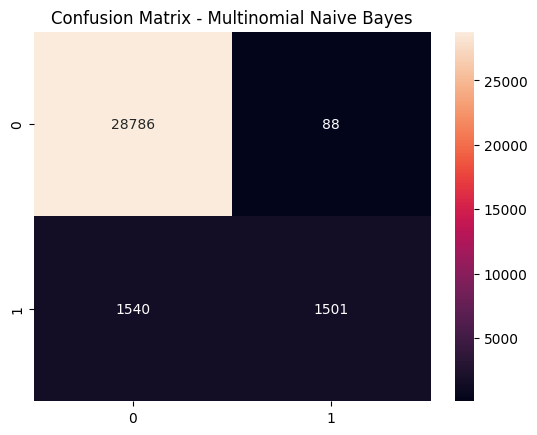

Logistic Regression - Accuracy: 0.9569794767350775
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28874
           1       0.90      0.61      0.73      3041

    accuracy                           0.96     31915
   macro avg       0.93      0.80      0.85     31915
weighted avg       0.96      0.96      0.95     31915



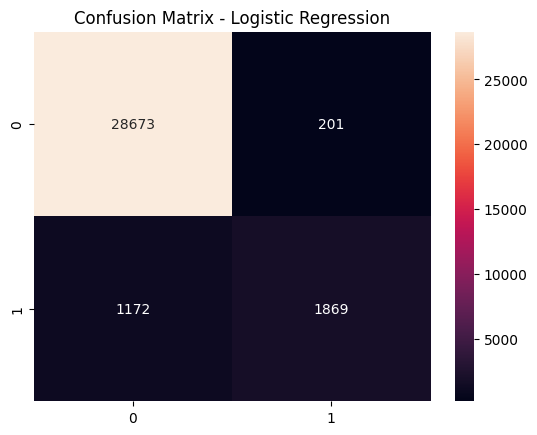

Linear SVC - Accuracy: 0.9598308005639982
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28874
           1       0.88      0.67      0.76      3041

    accuracy                           0.96     31915
   macro avg       0.92      0.83      0.87     31915
weighted avg       0.96      0.96      0.96     31915



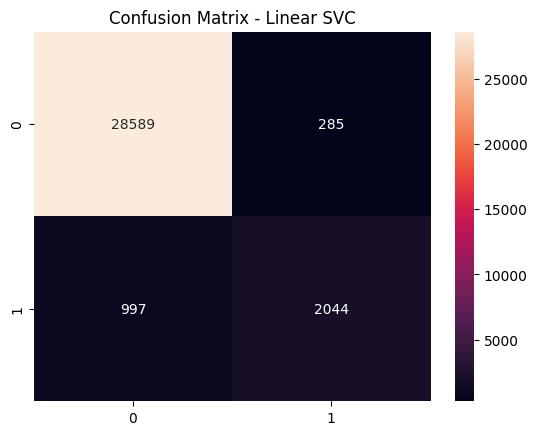

In [15]:
for name, model in models.items():
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    print(f"{name} - Accuracy: {accuracy_score(Y_test, Y_pred)}")
    print(classification_report(Y_test, Y_pred))
    sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

In [16]:
voting_clf = VotingClassifier(estimators=[(name, model) for name, model in models.items()])
voting_clf.fit(X_train, Y_train)
voting_pred = voting_clf.predict(X_test)
print("Ensemble Method (Voting Classifier) - Accuracy:", accuracy_score(Y_test, voting_pred))

Ensemble Method (Voting Classifier) - Accuracy: 0.9580448065173116


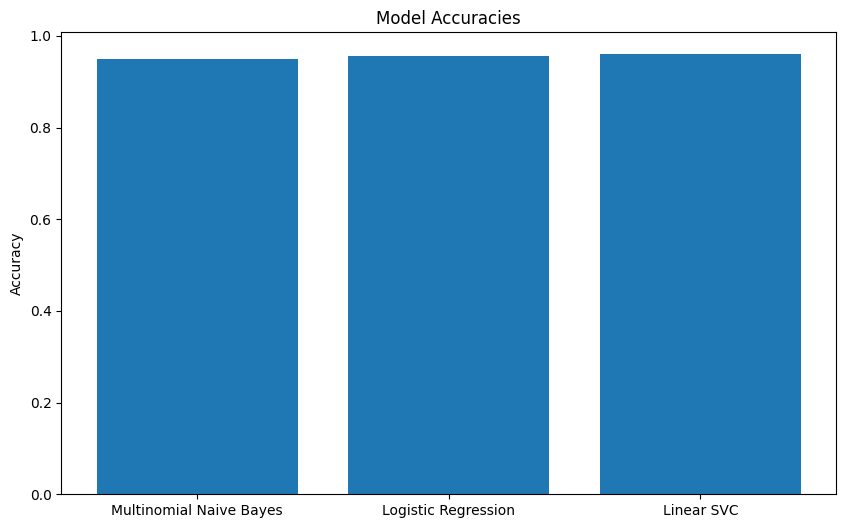

In [17]:
accuracies = [accuracy_score(Y_test, model.predict(X_test)) for model in models.values()]
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), accuracies)
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.show()

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [19]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(dataset['comment_text'])
sequences = tokenizer.texts_to_sequences(dataset['comment_text'])
X = pad_sequences(sequences, maxlen=10)
Y = dataset['toxic']

In [20]:
model = Sequential()
model.add(Embedding(10000, 128))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, Y, epochs=4, batch_size=32)

Epoch 1/4
4987/4987 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9376 - loss: 0.1967
Epoch 2/4
4987/4987 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9510 - loss: 0.1402
Epoch 3/4
4987/4987 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9562 - loss: 0.1230
Epoch 4/4
4987/4987 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9617 - loss: 0.1055


In [22]:
test_comments = ["I love you", "I hate you", "You're ugly", "You suck at video games", "I think you're talented"]
test_sequences = tokenizer.texts_to_sequences(test_comments)
test_padded = pad_sequences(test_sequences, maxlen=10)

In [23]:
predictions = model.predict(test_padded)
for comment, prediction in zip(test_comments, predictions):
    print(f"Comment: {comment} - Toxicity Probability: {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Comment: I love you - Toxicity Probability: 0.08916379511356354
Comment: I hate you - Toxicity Probability: 0.9735268354415894
Comment: You're ugly - Toxicity Probability: 0.9887987971305847
Comment: You suck at video games - Toxicity Probability: 0.9686542749404907
Comment: I think you're talented - Toxicity Probability: 0.11775729805231094
